
   ###  2D Stochastic Gaussian Simulation in Python for Engineers and Geoscientists 

### with GSLIB's SGSIM Program Converted to Python

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 


#### Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

This is a tutorial for / demonstration of **Kriging in Python with GSLIB's KB2D program translated to Python, wrappers and reimplementations of other GSLIB: Geostatistical Library methods** (Deutsch and Journel, 1997). 

This exercise demonstrates the kriging method in Python with wrappers and reimplimentation of GSLIB methods. The steps include:

1. generate a 2D model with sequential Gaussian simulation
2. sample from the simulation
3. calculate and visualize the kriged map

To accomplish this I have provide wrappers or reimplementation in Python for the following GSLIB methods:

1. sgsim - sequantial Gaussian simulation limited to 2D and unconditional
2. hist - histograms plots reimplemented with GSLIB parameters using python methods
3. locmap - location maps reimplemented with GSLIB parameters using python methods
4. pixelplt - pixel plots reimplemented with GSLIB parameters using python methods
5. locpix - my modification of GSLIB to superimpose a location map on a pixel plot reimplemented with GSLIB parameters using Python methods
5. affine - affine correction adjust the mean and standard deviation of a feature reimplemented with GSLIB parameters using Python methods

I have also started to translate the GSLIB support subfunctions to Python. Stay tuned.

The GSLIB source and executables are available at http://www.statios.com/Quick/gslib.html.  For the reference on using GSLIB check out the User Guide, GSLIB: Geostatistical Software Library and User's Guide by Clayton V. Deutsch and Andre G. Journel.  Overtime, more of the GSLIB programs will be translated to Python and there will be no need to have the executables.  For this workflow you will need sgsim.exe from GSLIB.com for windows and Mac OS executables from https://github.com/GeostatsGuy/GSLIB_MacOS.  

I did this to allow people to use these GSLIB functions that are extremely robust in Python. Also this should be a bridge to allow so many familar with GSLIB to work in Python as a kept the parameterization and displays consistent with GSLIB.  The wrappers are simple functions declared below that write the parameter files, run the GSLIB executable in the working directory and load and visualize the output in Python. This will be included on GitHub for anyone to try it out https://github.com/GeostatsGuy/.  

This was my first effort to translate the GSLIB Fortran to Python.  It was pretty easy so I'll start translating other critical GSLIB functions.  I've completed NSCORE, DECLUS, GAM, GAMV and now KB2D as of now.

#### Load the required libraries

The following code loads the required libraries.

In [1]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare functions

Here are the wrappers and reimplementations of GSLIB method along with two utilities to load GSLIB's Geo-EAS from data files into DataFrames and 2D Numpy arrays.  These are used in the testing workflow.  

In [2]:
# Some GeostatsPy Functions - by Michael Pyrcz, maintained at https://git.io/fNgR7.
# A set of functions to provide access to GSLIB in Python.
# GSLIB executables: nscore.exe, declus.exe, gam.exe, gamv.exe, vmodel.exe, kb2d.exe & sgsim.exe must be in the working directory 
# note, since I have now rewritten nscore, gam, gamv and kb2d one can just use these in Python
# available in the geostatspy package.
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt                          
image_type = 'tif'; dpi = 600

# utility to convert GSLIB Geo-EAS files to a 1D or 2D numpy ndarray for use with Python methods
def GSLIB2ndarray(data_file,kcol,nx,ny): 
    colArray = []
    if ny > 1:
        array = np.ndarray(shape=(ny,nx),dtype=float,order='F')
    else:
        array = np.zeros(nx)    
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])          # get the number of columns
        for icol in range(0, ncol):   # read over the column names
            head = [next(myfile) for x in range(1)]
            if icol == kcol:
                col_name = head[0].split()[0]       
        if ny > 1:
            for iy in range(0,ny):
                for ix in range(0,nx):
                    head = [next(myfile) for x in range(1)]
                    array[ny-1-iy][ix] = head[0].split()[kcol]
        else:
            for ix in range(0,nx):
                head = [next(myfile) for x in range(1)]
                array[ix] = head[0].split()[kcol]
    return array,col_name 

# utility to convert GSLIB Geo-EAS files to a pandas DataFrame for use with Python methods
def GSLIB2Dataframe(data_file):
    colArray = []
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])
        for icol in range(0, ncol):
            head = [next(myfile) for x in range(1)]
            colArray.append(head[0].split()[0])
        data = np.loadtxt(myfile, skiprows = 0)
        df = pd.DataFrame(data)
        df.columns = colArray
        return df

# histogram, reimplemented in Python of GSLIB hist with MatPlotLib methods, displayed and as image file
def hist(array,xmin,xmax,log,cumul,bins,weights,xlabel,title,fig_name):
    plt.figure(figsize=(8,6))
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency')  
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return

# histogram, reimplemented in Python of GSLIB hist with MatPlotLib methods (version for subplots)
def hist_st(array,xmin,xmax,log,cumul,bins,weights,xlabel,title):  
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency') 
    return

# location map, reimplemention in Python of GSLIB locmap with MatPlotLib methods
def locmap(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name):
    ixy = 0 
    plt.figure(figsize=(8,6))    
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return im

# location map, reimplemention in Python of GSLIB locmap with MatPlotLib methods (version for subplots)
def locmap_st(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    ixy = 0   
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return im           

# pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods
def pixelplt(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    plt.figure(figsize=(8,6))
    im = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels=np.linspace(vmin,vmax,100))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im,orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return im

# pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods(version for subplots)
def pixelplt_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    x = [];y = []; v = [] # use dummy since scatter plot controls legend min and max appropriately and contour does not!
    cs = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(x,y,s=None, c=v, marker=None,cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.clim(vmin,vmax)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return cs

# pixel plot and location map, reimplementation in Python of a GSLIB MOD with MatPlotLib methods
def locpix(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap,fig_name):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    plt.figure(figsize=(8,6))
    cs = plt.contourf(xx, yy, array, cmap=cmap,vmin=vmin, vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)  
    cbar = plt.colorbar(orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return cs

# pixel plot and location map, reimplementation in Python of a GSLIB MOD with MatPlotLib methods(version for subplots)
def locpix_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    cs = plt.contourf(xx, yy, array, cmap=cmap,vmin=vmin, vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xlabel)  
    plt.ylabel(ylabel)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    cbar = plt.colorbar(orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)

# affine distribution correction reimplemented in Python with numpy methods 
def affine(array,tmean,tstdev): 
    mean = np.average(array)
    stdev = np.std(array)  
    array = (tstdev/stdev)*(array - mean) + tmean
    return(array)   

def make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2=1,cc2=0,azi2=0,hmaj2=0,hmin2=0):
    if cc2 == 0:
        nst = 1
    var = dict([('nug', nug), ('nst', nst), ('it1', it1),('cc1', cc1),('azi1', azi1),('hmaj1', hmaj1), ('hmin1', hmin1), 
      ('it2', it2),('cc2', cc2),('azi2', azi2),('hmaj2', hmaj2), ('hmin2', hmin2)])
    if nug + cc1 + cc2 != 1:
        print('\x1b[0;30;41m make_variogram Warning: sill does not sum to 1.0, do not use in simulation \x1b[0m')
    if cc1 < 0 or cc2 < 0 or nug < 0 or hmaj1 < 0 or hmaj2 < 0 or hmin1 < 0 or hmin2 < 0:
        print('\x1b[0;30;41m make_variogram Warning: contributions and ranges must be all positive \x1b[0m')
    if hmaj1 < hmin1 or hmaj2 < hmin2:
        print('\x1b[0;30;41m make_variogram Warning: major range should be greater than minor range \x1b[0m')
    return var    

# sequential Gaussian simulation, 2D unconditional wrapper for sgsim from GSLIB (.exe must be in working directory)
def GSLIB_sgsim_2d_uncond(nreal,nx,ny,hsiz,seed,var,output_file):
    import os
    import numpy as np 
    
    nug = var['nug']
    nst = var['nst']; it1 = var['it1']; cc1 = var['cc1']; azi1 = var['azi1']; hmaj1 = var['hmaj1']; hmin1 = var['hmin1'] 
    it2 = var['it2']; cc2 = var['cc2']; azi2 = var['azi2']; hmaj2 = var['hmaj2']; hmin2 = var['hmin2']     
    max_range = max(hmaj1,hmaj2) 
    hmn = hsiz * 0.5   
    hctab = int(max_range/hsiz)*2 + 1

    sim_array = np.random.rand(nx,ny)

    file = open("sgsim.par", "w")
    file.write("              Parameters for SGSIM                                         \n")
    file.write("              ********************                                         \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETER:                                                        \n")
    file.write("none                          -file with data                              \n")
    file.write("1  2  0  3  5  0              -  columns for X,Y,Z,vr,wt,sec.var.          \n")
    file.write("-1.0e21 1.0e21                -  trimming limits                           \n")
    file.write("0                             -transform the data (0=no, 1=yes)            \n")
    file.write("none.trn                      -  file for output trans table               \n")
    file.write("1                             -  consider ref. dist (0=no, 1=yes)          \n")
    file.write("none.dat                      -  file with ref. dist distribution          \n")
    file.write("1  0                          -  columns for vr and wt                     \n")
    file.write("-4.0    4.0                   -  zmin,zmax(tail extrapolation)             \n")
    file.write("1      -4.0                   -  lower tail option, parameter              \n")
    file.write("1       4.0                   -  upper tail option, parameter              \n")
    file.write("0                             -debugging level: 0,1,2,3                    \n")
    file.write("nonw.dbg                      -file for debugging output                   \n")
    file.write(str(output_file) + "           -file for simulation output                  \n")
    file.write(str(nreal) + "                 -number of realizations to generate          \n")
    file.write(str(nx) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write(str(ny) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write("1 0.0 1.0                     - nz zmn zsiz                                \n")
    file.write(str(seed) + "                  -random number seed                          \n")
    file.write("0     8                       -min and max original data for sim           \n")
    file.write("12                            -number of simulated nodes to use            \n")
    file.write("0                             -assign data to nodes (0=no, 1=yes)          \n")
    file.write("1     3                       -multiple grid search (0=no, 1=yes),num      \n")
    file.write("0                             -maximum data per octant (0=not used)        \n")
    file.write(str(max_range) + " " + str(max_range) + " 1.0 -maximum search  (hmax,hmin,vert) \n")
    file.write(str(azi1) + "   0.0   0.0       -angles for search ellipsoid                 \n")
    file.write(str(hctab) + " " + str(hctab) + " 1 -size of covariance lookup table        \n")
    file.write("0     0.60   1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC        \n")
    file.write("none.dat                      -  file with LVM, EXDR, or COLC variable     \n")
    file.write("4                             -  column for secondary variable             \n")
    file.write(str(nst) + " " + str(nug) + "  -nst, nugget effect                          \n")
    file.write(str(it1) + " " + str(cc1) + " " +str(azi1) + " 0.0 0.0 -it,cc,ang1,ang2,ang3\n")
    file.write(" " + str(hmaj1) + " " + str(hmin1) + " 1.0 - a_hmax, a_hmin, a_vert        \n")
    file.write(str(it2) + " " + str(cc2) + " " +str(azi2) + " 0.0 0.0 -it,cc,ang1,ang2,ang3\n")
    file.write(" " + str(hmaj2) + " " + str(hmin2) + " 1.0 - a_hmax, a_hmin, a_vert        \n")  
    file.close()

    os.system('"sgsim.exe sgsim.par"')       
    sim_array = GSLIB2ndarray(output_file,0,nx,ny)         
    return(sim_array[0])

# extract regular spaced samples from a model   
def regular_sample(array,xmin,xmax,ymin,ymax,step,mx,my,name):
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    iiy = 0
    for iy in range(0,ny):
        if iiy >= my:
            iix = 0
            for ix in range(0,nx):
                if iix >= mx:
                    x.append(xx[ix,iy]);y.append(yy[ix,iy]); v.append(array[ix,iy])
                    iix = 0; iiy = 0
                iix = iix + 1
        iiy = iiy + 1
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)

def random_sample(array,xmin,xmax,ymin,ymax,step,nsamp,name):
    import random as rand
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax-1, ymin-1, -1*step))
    ny = xx.shape[0]
    nx = xx.shape[1]
    sample_index = rand.sample(range((nx)*(ny)), nsamp)
    for isamp in range(0,nsamp):
        iy = int(sample_index[isamp]/ny)
        ix = sample_index[isamp] - iy*nx
        x.append(xx[iy,ix])
        y.append(yy[iy,ix])
        v.append(array[iy,ix])
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df) 

In [6]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting

import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB

In [7]:
os.chdir("c:/PGE383")                                   # set the working directory

In [8]:
df = pd.read_csv("sample_data_MV_biased.csv")                     # read a .csv file in as a DataFrame
Npor, vr,nr = geostats.nscore(df,'Porosity')
df['Npor'] = Npor
#print(df.iloc[0:5,:])                                  # display first 4 samples in the table as a preview
df.head(n=30)                                               # we could also use this command for a table preview 
df.describe()

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI,Npor
count,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,3.680000e+02
mean,293.260870,499.565217,520.644022,0.597826,0.127026,85.617362,4791.736646,1.039758e-03
std,169.058258,289.770794,277.412187,0.491004,0.030642,228.362654,974.560569,9.973494e-01
min,0.000000,0.000000,9.000000,0.000000,0.041122,0.094627,1981.177309,-2.672206e+00
25%,150.500000,240.000000,269.000000,0.000000,0.103412,2.297348,4110.728374,-6.723581e-01
50%,296.000000,500.000000,539.000000,1.000000,0.125842,10.377292,4713.325533,3.774758e-15
75%,439.500000,762.500000,769.000000,1.000000,0.148623,50.581288,5464.043562,6.723581e-01
max,586.000000,990.000000,999.000000,1.000000,0.210258,1991.097723,7561.250336,2.998021e+00


These are a variety of GSLIB subfunctions required by the GSLIB functions that I have converted to Python.  I will continue to convert the subfunctions and include them as needed by the GSLIB functions that I convert. All are available with geostatspy.

In [138]:
import math
import numpy as np
import numpy.linalg as linalg
from numba import jit

def dlocate(xx,iis,iie,x):
    from bisect import bisect
    n = len(xx)
    if iie <= iis:
        iis = 0; ie = n-1
    array = xx[iis:iie-1]  # this is accounting for swith to 0,...,n-1 index
    j = bisect(array,x)
    return j

def dsortem(ib,ie,a,iperm,b=0,c=0,d=0,e=0,f=0,g=0,h=0):
    a = a[ib:ie]
    inds = a.argsort()
    a = np.copy(a[inds]) # deepcopy forces pass to outside scope
    if(iperm == 1):
        return a
    b_slice = b[ib:ie]
    b = b_slice[inds]    
    if iperm == 2:
        return a,b
    c_slice = c[ib:ie]
    c = c_slice[inds]    
    if iperm == 3:
        return a, b, c
    d_slice = d[ib:ie]
    d = d_slice[inds]    
    if iperm == 4:
        return a, b, c, d
    e_slice = e[ib:ie]
    e = e_slice[inds]    
    if iperm == 5:
        return a, b, c, d, e 
    f_slice = f[ib:ie]
    f = f_slice[inds]
    if iperm == 6:
        return a, b, c, d, e, f 
    g_slice = g[ib:ie]
    g = g_slice[inds]
    if iperm == 7:
        return a, b, c, d, e, f, h     
    h_slice = h[ib:ie]
    h = h_slice[inds]
    return a, b, c, d, e, f, h

def backtr_value(vrgs,vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar):   
    EPSLON=1.0e-20
    nt = len(vr) # number of data to transform 
# Value in the lower tail?    1=linear, 2=power, (3 and 4 are invalid):
    if vrgs <= vrg[0]:
        backtr = vr[0]
        cdflo  = gcum(vrg[0])
        cdfbt  = gcum(vrgs)
        if ltail == 1:
            backtr = dpowint(0.0,cdflo,zmin,vr[0],cdfbt,1.0)
        elif ltail == 2:
            cpow   = 1.0 / ltpar
            backtr = dpowint(0.0,cdflo,zmin,vr[0],cdfbt,cpow)
# Value in the upper tail?     1=linear, 2=power, 4=hyperbolic:
    elif vrgs >= vrg[nt-1]:
        backtr = vr[nt-1]
        cdfhi  = gcum(vrg[nt-1])
        cdfbt  = gcum(vrgs)
        if utail == 1:
            backtr = dpowint(cdfhi,1.0,vr[nt-1],zmax,cdfbt,1.0)
        elif utail == 2: 
            cpow   = 1.0 / utpar
            backtr = dpowint(cdfhi,1.0,vr[nt-1],zmax,cdfbt,cpow)
        elif utail == 4:
            plambda = (vr[nt-1]**utpar)*(1.0-gcum(vrg[nt-1]))
            backtr = (plambda/(1.0-gcum(vrgs)))**(1.0/utpar)
    else:
# Value within the transformation table:
        j = dlocate(vrg,1,nt,vrgs)
        j = max(min((nt-2),j),1)
        backtr = dpowint(vrg[j],vrg[j+1],vr[j],vr[j+1],vrgs,1.0)
    return backtr

def backtr(df,vcol,vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar):   
    EPSLON=1.0e-20
    nd = len(df); nt = len(vr) # number of data to transform and number of data in table
    backtr = np.zeros(nd)
    vrgs = df[vcol].values
# Value in the lower tail?    1=linear, 2=power, (3 and 4 are invalid):
    for id in range(0,nd):
        if vrgs[id] <= vrg[0]:
            backtr[id] = vr[0]
            cdflo  = gcum(vrg[0])
            cdfbt  = gcum(vrgs[id])
            if ltail == 1:
                backtr[id] = dpowint(0.0,cdflo,zmin,vr[0],cdfbt,1.0)
            elif ltail == 2:
                cpow   = 1.0 / ltpar
                backtr[id] = dpowint(0.0,cdflo,zmin,vr[0],cdfbt,cpow)
# Value in the upper tail?     1=linear, 2=power, 4=hyperbolic:
        elif vrgs[id] >= vrg[nt-1]:
            backtr[id] = vr[nt-1]
            cdfhi  = gcum(vrg[nt-1])
            cdfbt  = gcum(vrgs[id])
            if utail == 1:
                backtr[id] = dpowint(cdfhi,1.0,vr[nt-1],zmax,cdfbt,1.0)
            elif utail == 2: 
                cpow   = 1.0 / utpar
                backtr[id] = dpowint(cdfhi,1.0,vr[nt-1],zmax,cdfbt,cpow)
            elif utail == 4:
                plambda = (vr[nt-1]**utpar)*(1.0-gcum(vrg[nt-1]))
                backtr[id] = (plambda/(1.0-gcum(vrgs)))**(1.0/utpar)
        else:
# Value within the transformation table:
            j = dlocate(vrg,1,nt,vrgs[id])
            j = max(min((nt-2),j),1)
            backtr[id] = dpowint(vrg[j],vrg[j+1],vr[j],vr[j+1],vrgs[id],1.0)
    return backtr

def gauinv(p):
    lim = 1.0e-10; p0 = -0.322232431088; p1 = -1.0; p2 = -0.342242088547
    p3 = -0.0204231210245; p4 = -0.0000453642210148; q0 = 0.0993484626060
    q1 = 0.588581570495; q2 = 0.531103462366; q3 = 0.103537752850; q4 = 0.0038560700634

# Check for an error situation:
    if p < lim:
        xp = -1.0e10
        return xp
    if p > (1.0-lim):
        xp =  1.0e10
        return xp    

# Get k for an error situation:
    pp = p
    if p > 0.5: pp = 1 - pp
    xp   = 0.0
    if p == 0.5: 
        return xp

# Approximate the function:
    y  = np.sqrt(np.log(1.0/(pp*pp)))
    xp = float(y + ((((y*p4+p3)*y+p2)*y+p1)*y+p0) /
            ((((y*q4+q3)*y+q2)*y+q1)*y+q0) )
    if float(p) == float(pp): 
        xp = -xp
    return xp

def gcum(x):
    z = x
    if z < 0:  
        z = -z
    t= 1./(1.+ 0.2316419*z)
    gcum = t*(0.31938153   + t*(-0.356563782 + t*(1.781477937 +
           t*(-1.821255978 + t*1.330274429))))
    e2= 0.0
    
# standard deviations out gets treated as infinity:
    if z <= 6: 
        e2 = np.exp(-z*z/2.0)*0.3989422803
    gcum = 1.0- e2 * gcum
    if x >= 0.0: 
        return gcum
    gcum = 1.0 - gcum
    return gcum

def dpowint(xlow,xhigh,ylow,yhigh,xval,pwr):
    EPSLON = 1.0e-20
    if (xhigh-xlow) < EPSLON:
        dpowint = (yhigh+ylow)/2.0
    else:
        dpowint = ylow + (yhigh-ylow)*(((xval-xlow)/(xhigh-xlow))**pwr)
    return dpowint

#@jit(nopython=True) # all NumPy array operations included in this function for precompile with NumBa
def setup_rotmat(c0,nst,it,cc,ang):
    DTOR=3.14159265/180.0; EPSLON=0.000000; PI=3.141593
# The first time around, re-initialize the cosine matrix for the
# variogram structures:
    rotmat = np.zeros((4,nst))
    maxcov = c0
    for js in range(0,nst):
        azmuth = (90.0-ang[js])*DTOR
        rotmat[0,js] =  math.cos(azmuth)
        rotmat[1,js] =  math.sin(azmuth)
        rotmat[2,js] = -1*math.sin(azmuth)
        rotmat[3,js] =  math.cos(azmuth)
        if it[js] == 4:
            maxcov = maxcov + 9999.9
        else:
            maxcov = maxcov + cc[js]
    return rotmat, maxcov
     
@jit(nopython=True) # all NumPy array operations included in this function for precompile with NumBa
def cova2(x1,y1,x2,y2,nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov):
    DTOR=3.14159265/180.0; EPSLON=0.0000001; PI=3.141593
                      
# Check for very small distance:
    dx = x2-x1
    dy = y2-y1
#    print(dx,dy)
    if (dx*dx+dy*dy) < EPSLON:
        cova2 = maxcov
        return cova2

# Non-zero distance, loop over all the structures:
    cova2 = 0.0
    for js in range(0,nst):
#        print(js)
#        print(rotmat)
# Compute the appropriate structural distance:
        dx1 = (dx*rotmat[0,js] + dy*rotmat[1,js])
        dy1 = (dx*rotmat[2,js] + dy*rotmat[3,js])/anis[js]
        h   = math.sqrt(max((dx1*dx1+dy1*dy1),0.0))
        if it[js] == 1:

# Spherical model:
            hr = h/aa[js]
            if hr < 1.0: 
                cova2 = cova2 + cc[js]*(1.-hr*(1.5-.5*hr*hr))
            elif it[js] == 2:
                
# Exponential model:
                cova2 = cova2 + cc[js]*np.exp(-3.0*h/aa[js])
            elif it[js] == 3:

# Gaussian model:
                hh=-3.0*(h*h)/(aa[js]*aa[js])
                cova2 = cova2 +cc[js]*np.exp(hh)
            elif it[js] == 4:

# Power model:
                cov1  = PMX - cc[js]*(h**aa[js])
                cova2 = cova2 + cov1      
    return cova2

def sqdist2(x1,y1,x2,y2,ist,rotmat,anis):
# Compute component distance vectors and the squared distance:
    dx = x1 - x2
    dy = y1 - y2
    dx1 = (dx*rotmat[0,ist] + dy*rotmat[1,ist])
    dy1 = (dx*rotmat[2,ist] + dy*rotmat[3,ist])/anis[ist]
    sqdist = (dx1*dx1+dy1*dy1)  
    return sqdist

def ksol_numpy(neq,a,r):    # using Numpy methods
    a = a[0:neq*neq]             # trim the array
    a = np.reshape(a,(neq,neq))  # reshape to 2D
    ainv = linalg.inv(a)         # invert matrix
    r = r[0:neq]                 # trim the array
    s = np.matmul(ainv,r)        # matrix multiplication
    return s

def setrot(ang1,ang2,sang1,anis1,anis2,sanis1,nst,MAXROT):
    DEG2RAD = 3.141592654/180.0; EPSLON=1.e-20
    rotmat = np.zeros((MAXROT+1,3,3))
    if ang1 >= 0.0 and ang1 < 270.0:
        alpha = (90.0   - ang1) * DEG2RAD
    else:
        alpha = (450.0  - ang1) * DEG2RAD
# Get the required sines and cosines:
    sina  = math.sin(alpha)
    cosa  = math.cos(alpha)
# Construct the rotation matrix in the required memory:
    afac1 = 1.0 / (max(anis1,EPSLON))
    rotmat[0,1,1] = cosa
    rotmat[0,1,2] = sina
    rotmat[0,2,1] = afac1*(-sina)
    rotmat[0,2,2] = afac1*(cosa)
# 2nd structure if present    
    if nst > 1:
        if ang2 >= 0.0 and ang2 < 270.0:
            alpha = (90.0   - ang2) * DEG2RAD
        else:
            alpha = (450.0  - ang2) * DEG2RAD
# Get the required sines and cosines:
        sina  = math.sin(alpha)
        cosa  = math.cos(alpha)
# Construct the rotation matrix in the required memory:
        afac2 = 1.0 / (max(anis2,EPSLON))
        rotmat[1,1,1] = cosa
        rotmat[1,1,2] = sina
        rotmat[1,2,1] = afac1*(-sina)
        rotmat[1,2,2] = afac1*(cosa)
# search rotation
    if sang1 >= 0.0 and sang1 < 270.0:
        alpha = (90.0   - sang1) * DEG2RAD
    else:
        alpha = (450.0  - sang1) * DEG2RAD
# Get the required sines and cosines:
    sina  = math.sin(alpha)
    cosa  = math.cos(alpha)
# Construct the rotation matrix in the required memory:
    afac1 = 1.0 / (max(sanis1,EPSLON))
    rotmat[MAXROT,1,1] = cosa
    rotmat[MAXROT,1,2] = sina
    rotmat[MAXROT,2,1] = afac1*(-sina)
    rotmat[MAXROT,2,2] = afac1*(cosa)
# Return to calling program:
    return rotmat

def sqdist(x1,y1,z1,x2,y2,z2,ind,rotmat):
# Compute component distance vectors and the squared distance:
    dx = x1 - x2
    dy = y1 - y2
    dz = 0.0
    sqdist = 0.0
    for i in range(0,2):
        cont   = rotmat[ind,i,1] * dx + rotmat[ind,i,2] * dy
        sqdist = sqdist + cont * cont
    return sqdist

def ctable(MAXNOD,MAXCXY,MAXCTX,MAXCTY,MAXXYZ,isrot,nx,ny,nst,c0,cc,aa,it,ang,anis,global_rotmat,radsqd):
   
# Declare constants
    TINY = 1.0e-10
    PMX = 9999.9
    MAXROT=2
# Size of the look-up table:
    tmp = np.zeros(MAXXYZ)
    MAXORD = MAXXYZ
    if (nx*ny)  < MAXCXY: 
        MAXORD = MAXCXY
     
    order = np.zeros(MAXORD)
    nctx = int(min(((MAXCTX-1)/2),(nx-1)))
    ncty = int(min(((MAXCTY-1)/2),(ny-1)))
    
#    print('CTable check')
#    print('nctx ' + str(nctx) + ', ncty ' + str(ncty))
    
    ixnode = np.zeros(MAXXYZ)
    iynode = np.zeros(MAXXYZ)
    covtab = np.zeros((MAXCTX,MAXCTY))
# Initialize the covariance subroutine and cbb at the same time:
    rotmat, maxcov = setup_rotmat(c0,nst,it,cc,ang)
    cbb = cova2(0.0,0.0,0.0,0.0,nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)

# Now, set up the table and keep track of the node offsets that are
# within the search radius:
    nlooku = -1 # adjusted for 0 origin
    for i in range(-nctx,nctx+1):   # cover entire range   
        xx = i * xsiz
        ic = nctx + i
        for j in range(-ncty,ncty+1):   # cover entire range      
            yy = j * ysiz
            jc = ncty + j

            covtab[ic,jc] = cova2(0.0,0.0,xx,yy,nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
#            print('cov table offset'); print(xx,yy); print(covtab[ic,jc])
            hsqd = sqdist(0.0,0.0,0.0,xx,yy,0.0,MAXROT,global_rotmat)
            if hsqd <= radsqd: 
                nlooku = nlooku + 1

# We want to search by closest variogram distance (and use the
# anisotropic Euclidean distance to break ties:
                tmp[nlooku]   = - (covtab[ic,jc] - TINY*hsqd)
                order[nlooku] = (jc)*MAXCTX+ic
#    print('populated presort'); print(tmp,order) 
# Finished setting up the look-up table, now order the nodes such
# that the closest ones, according to variogram distance, are searched
# first. Note: the "loc" array is used because I didn't want to make
# special allowance for 2 byte integers in the sorting subroutine:
                              
    nlooku = nlooku + 1
#    print('nlooku' + str(nlooku)); print('MAXCTX' + str(MAXCTX))
    tmp, order = dsortem(0,nlooku,tmp,2,b=order)
#    print('populated postsort'); print(tmp,order)
    for il in range(0,nlooku):                                    
        loc = int(order[il])
        iy  = int((loc-0)/MAXCTX)
        ix  = loc - (iy-0)*MAXCTX
        iynode[il] = int(iy)
        ixnode[il] = int(ix)
#    print('populated ix, iy node list'); print(ixnode, iynode)
                                   
    return covtab,tmp,order,ixnode,iynode,nlooku,nctx,ncty

def srchnd(ix,iy,sim,noct,nodmax,ixnode,iynode,nlooku,nctx,ncty,UNEST):

# Consider all the nearby nodes until enough have been found:
    ncnode = 0; 
    icnode = np.zeros(nodmax,dtype=int); icnode.fill(-1) 
    cnodev = np.zeros(nodmax);cnodex = np.zeros(nodmax); cnodey = np.zeros(nodmax);
    
#    print('Node search at '); print(ix,iy)
#    print('nlooku'); print(nlooku)
    if noct > 0:
        ninoct = np.zeros(8)
    for il in range(0,nlooku):   
        if ncnode == nodmax: return ncnode, icnode, cnodev, cnodex, cnodey
        i = ix + (int(ixnode[il])-nctx)
        j = iy + (int(iynode[il])-ncty)
        #print('i,j'); print(i,j)
        if i < 0 or j < 0: continue
        if i >= nx or j >= ny: continue
        ind = i + (j-1)*nx 
#        print('ind'); print(ind)
        if sim[ind] > UNEST:

# Check the number of data already taken from this octant:
            if noct > 0: 
                idx = ix - i
                idy = iy - j
                iq = 8
                if idx <= 0 and idy > 0: iq = 5
                if idx > 0 and idy >= 0: iq = 6
                if idx < 0 and idy <= 0: iq = 7
                ninoct[iq] = ninoct[iq] + 1
                if ninoct[iq] > noct: continue
            icnode[ncnode] = il
            cnodex[ncnode] = xmn + (i)*xsiz # adjust for 0 origin
            cnodey[ncnode] = ymn + (j)*ysiz
            cnodev[ncnode] = sim[ind]  
            ncnode = ncnode + 1  # moved to account for origin 0
    return ncnode, icnode, cnodev, cnodex, cnodey

def krige(ix,iy,xx,yy,lktype,x,y,vr,sec,colocorr,lvm,close,covtab,nctx,ncty,icnode,ixnode,iynode,cnodev,cnodex,cnodey,nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov,MAXCTX,MAXCTY,MAXKR1,MAXKR2):
    EPSLON = 1.0e-20
    cur_index  = ix + (iy-1)*nx
#    print('krige at grid '); print(ix,iy) 
#    print('krige at node '); print(xx,yy)
#    print('Check ixnode '); print(ixnode); print(iynode)
    nclose = len(close)
    ncnode = (icnode >= 0).sum() 
#    print('In kriging, maxcov = ' + str(maxcov))
#    print('kriging')
#    print('nclose ' + str(nclose) + ', ncnode ' + str(ncnode))
    print('MAXKR1'); print(MAXKR1)
    vra = np.zeros(MAXKR1); vrea = np.zeros(MAXKR1)
    r = np.zeros(MAXKR1); rr = np.zeros(MAXKR1); s = np.zeros(MAXKR1); a = np.zeros(MAXKR2)
    cbb = cova2(0,0,0,0,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov) 
    print(r.shape)
# Local mean
    if ktype == 2:
        gmean = lvm[cur_index]
    else:
        gmean = 0.0

# Size of the kriging system:
    first = False
    na    = nclose + ncnode
    if lktype == 0: neq = na
    if lktype == 1: neq = na + 1
    if lktype == 2: neq = na
    if lktype == 3: neq = na + 2
    if lktype == 4: neq = na + 1
    print('neq'); print(neq)
        
# Set up kriging matrices:
    iin=-1 # acocunting for 0 origin
#    print('krige na' + str(na))
    for j in range(0,na):

# Sort out the actual location of point "j"
        if j < nclose: # adjusted for 0 index origin
            index  = int(close[j])
            x1     = x[index]
            y1     = y[index]
            vra[j] = vr[index]
#            print('kriging data: index = ' + str(index) + ', x,y ' + str(x1) + ',' + str(y1) + ', value = ' + str(vra[j]))
            if sec.shape[0] > 1: 
                vrea[j]= sec[index];
            else:
                vrea[j] = 0.0 # added this - no effect
            if lktype == 2: vra[j] = vra[j] - vrea[j]
        else:
            
# It is a previously simulated node (keep index for table look-up):
#            print(j)
            index  = j-(nclose) # adjust for 0 index
            x1     = cnodex[index]
            y1     = cnodey[index]
            vra[j] = cnodev[index]
            ind    = icnode[index]
#            print('kriging node: index = ' + str(index) + ', x,y ' + str(x1) + ',' + str(y1) + ', value = ' + str(vra[j])) 
            ix1    = ix + (int(ixnode[ind])-nctx-1)
            iy1    = iy + (int(iynode[ind])-ncty-1)
#            print('ix1, iy1 = '); print(ix1,iy1)
            index  = ix1 + (iy1-1)*nx
            if lktype == 2: 
                vrea[j]= lvm[index]
                vra[j] = vra[j] - vrea[j]
        for i in range(0,na): # we need the full matrix 
#            print('kriging indice populated' + str(j) + ',' + str(i))
# Sort out the actual location of point "i"
            if i < nclose:
                index  = int(close[i]) # adjust for 0 index
                x2     = x[index]
                y2     = y[index]
            else:

# It is a previously simulated node (keep index for table look-up):
                #print('i = ' + str(i) + ',nclose = ' + str(nclose) + ', na = ' + str(na))
                index  = i-(nclose)
                x2     = cnodex[index]
                y2     = cnodey[index]
                ind    = icnode[index]
#                print('previous node index' + str(ind))
                ix2    = ix + (int(ixnode[ind])-nctx-1)
                iy2    = iy + (int(iynode[ind])-ncty-1)

# Now, get the covariance value:
            iin = iin + 1
#            print('kriging data location = '); print(x2,y2)
# Decide whether or not to use the covariance look-up table:
            if j <= nclose or i <= nclose:
                cov = cova2(x1,y1,x2,y2,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov)
                a[iin] = cov
            else:

# Try to use the covariance look-up (if the distance is in range):
#                ii = nctx + 1 + (ix1 - ix2)
#                jj = ncty + 1 + (iy1 - iy2)
                cov = cova2(x1,y1,x2,y2,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov)
#                if ii < 0 or ii >= MAXCTX or jj < 0 or jj >= MAXCTY:
#                    cov = cova2(x1,y1,x2,y2,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov)
#                else:
#                    cov = covtab[ii,jj]
#                print(x1,y1,x2,y2,cov)
                a[iin] = cov

# Get the RHS value (possibly with covariance look-up table):
        if j <= nclose:
#            print(cc,aa,it,ang,anis,rotmat,maxcov)
            cov = cova2(xx,yy,x1,y1,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov)
            r[j] = cov
        else:

# Try to use the covariance look-up (if the distance is in range):
#            ii = nctx + 1 + (ix - ix1)
#            jj = ncty + 1 + (iy - iy1)
    
#            print('RHS ctable coord' + str(ii) + ',' + str(jj))
#            print('ix,iy ='); print(ix,iy)
#            print('ix1,iy1'); print(ix1,iy1)
#            if ii < 0 or ii >= MAXCTX or jj < 0 or jj >= MAXCTY: # adjusted for origin 0
#                print('Not using covariance table')
#                cov = cova2(xx,yy,x1,y1,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov)    
#            else:
#               cov = covtab[ii,jj]
            cov = cova2(xx,yy,x1,y1,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov) 
            r[j] = cov
#        print('kriging, writing RHS '+ str(j) + ',' + str(cov) + 'loc_est' + str(xx) + ',' + str(yy) + 'data' + str(x1) + ',' + str(y1))
        rr[j] = r[j]


# Addition of OK constraint:
    if lktype == 1 or lktype == 3:
        for i in range(0,j):
            iin    = iin + 1
            a[iin] = 1.0
        iin       = iin + 1
        a[iin]    = 0.0
        r[na]  = 1.0
        rr[na] = 1.0

# Addition of the External Drift Constraint:
    if lktype == 3:
        edmin =  999999.
        edmax = -999999.
        for i in range(0,na):
            iin    = iin + 1
            a[iin] = vrea(i)
            if a[iin] <edmin: edmin = a[iin]
            if a[iin] > edmax: edmax = a[iin]
        iin       = iin + 1
        a[iin]   = 0.0
        iin      = iin + 1
        a[iin]    = 0.0
        ind      = ix + (iy-1)*nx
        r[na+1]  = lvm[ind]
        rr[na+1] = r[na+1]
        if (edmax-edmin) < EPSLON: neq = neq - 1

# Addition of Collocated Cosimulation Constraint:
    if lktype == 4:
        sfmin =  1.0e21
        sfmax = -1.0e21
        for i in range(0,na):
            iin    = iin + 1
            a[iin] = colocorr*r[i]
            if a[iin] < sfmin: sfmin = a[iin]
            if a[iin] > sfmax: sfmax = a[iin]
        iin    = iin + 1
        a[iin] = 1.0
        ii     = na + 1
        r[ii]  = colocorr
        rr[ii] = r[ii]
        if (sfmax-sfmin) < EPSLON: neq = neq - 1

# Solve the Kriging System:
#    print('neq = ' + str(neq)); 
#    print('a'); print(a)
#    print('r'); print(r)
#    print('data'); print(vra)
    if neq == 1 and lktype != 3:
#        print('neq = 1 '); print(a,r)
        s[0]  = r[0] / a[0]
    else:
        s = ksol_numpy(neq,a,r)
        ising = 0 # need to figure this out
#        print('s'); print(s)

# Compute the estimate and kriging variance.  Recall that kriging type
#     0 = Simple Kriging:
#     1 = Ordinary Kriging:
#     2 = Locally Varying Mean:
#     3 = External Drift:
#     4 = Collocated Cosimulation:

#    print('kriging weights'); print(s)
    cmean  = 0.0
#    print('cbb = ' + str(cbb))
    cstdev = cbb 
    sumwts = 0.0
    for i in range(0,na):
        cmean  = cmean  + s[i]*vra[i]
        cstdev = cstdev - s[i]*rr[i]
        sumwts = sumwts + s[i]
    if lktype == 1: cstdev = cstdev - s[na+1]
    if lktype == 2: cmean  = cmean + gmean
    if lktype == 4:
        ind    = ix + (iy-1)*nx
        print(ind)
        print('s'); print(s.shape)
        print('lvm'); print(lvm.shape)
        cmean  = cmean  + s[na]*lvm[cur_index]
        cstdev = cstdev - s[na] *rr[na]

# Error message if negative variance:
    if cstdev < 0.0:
#        print('ERROR: Negative Variance: ' + str(cstdev))
        cstdev = 0.0
    cstdev = math.sqrt(max(cstdev,0.0))
#    print('kriging estimate and variance' + str(cmean) + ', ' + str(cstdev))
    return cmean, cstdev

def getindex(nc,cmn,csiz,loc):
    ic = min(int((loc - cmn) / csiz), nc - 1)
    return ic


In [139]:
import math                        # for trig and constants
import scipy.spatial as sp         # for fast nearest nearbour search
from statsmodels.stats.weightstats import DescrStatsW
#from numba import jit             # for precompile speed up 
# GSLIB's KB2D program (Deutsch and Journel, 1998) converted from the original Fortran to Python 
# translated by Michael Pyrcz, the University of Texas at Austin (Jan, 2019)

def sgsim(df,xcol,ycol,vcol,wcol,scol,tmin,tmax,itrans,ismooth,dftrans,tcol,twtcol,zmin,zmax,ltail,ltpar,utail,utpar,nsim,
          nx,xmn,xsiz,ny,ymn,ysiz,seed,ndmin,ndmax,nodmax,mults,nmult,noct,radius,radius1,sang1,
          mxctx,mxcty,ktype,colocorr,sec_map,vario):
    
# Parameters from sgsim.inc    
    MAXNST=2; MAXROT=2; UNEST=-99.0; EPSLON=1.0e-20; VERSION=2.907
    KORDEI=12; MAXOP1=KORDEI+1; MAXINT=2**30
    
    
# Set other parameters
    np.random.seed(seed)
    nxy = nx*ny
    sstrat = 0 # search data and nodes by default, turned off if unconditional
    radsqd = radius * radius
    sanis1 = radius1/radius
    if ktype == 4: varred = 1.0
        
# load the variogram
    nst = int(vario['nst'])
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst,dtype=int)
    ang = np.zeros(nst); anis = np.zeros(nst)
    
    c0 = vario['nug']; 
    cc[0] = vario['cc1']; it[0] = vario['it1']; ang[0] = vario['azi1']; 
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:
        cc[1] = vario['cc2']; it[1] = vario['it2']; ang[1] = vario['azi2']; 
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];        

# Set the constants
    MAXCTX = mxctx
    MAXCTY = mxcty
    MAXCXY = MAXCTX * MAXCTY
    MAXX   = nx
    MAXY   = ny
    MAXZ   = 1 # assuming 2D for now
    MXY  = MAXX * MAXY
    if MXY < 100: MXY = 100
    MAXNOD = nodmax
    MAXSAM = ndmax
    MAXKR1 = MAXNOD + MAXSAM + 1
    print('MAXKR1'); print(MAXKR1)
    MAXKR2 = MAXKR1 * MAXKR1
    MAXSBX = 1
    if nx >  1:
        MAXSBX = int(nx/2)
        if MAXSBX > 50: MAXSBX=50
    MAXSBY = 1
    if ny > 1: 
        MAXSBY = int(ny/2)
        if MAXSBY > 50: MAXSBY=50

    MAXSBZ = 1
    MAXSB = MAXSBX*MAXSBY*MAXSBZ
    
# Declare arrays

    dist = np.zeros(ndmax)
    nums = np.zeros(ndmax,dtype = int)
    
# Perform some quick checks
    if nx > MAXX or ny> MAXY:
        print('ERROR: available grid size: ' + str(MAXX) + ',' + str(MAXY) + ',' + str(MAXZ) +'.')
        print('       you have asked for : ' + str(nx) + ',' + str(ny) + ',' + str(nz) + '.')
        return sim
    if ltail != 1 and ltail != 2:
        print('ERROR invalid lower tail option ' + str(ltail))
        print('      only allow 1 or 2 - see GSLIB manual ')
        return sim
    if utail != 1 and utail != 2 and utail != 4:
        print('ERROR invalid upper tail option ' + str(ltail))
        print('      only allow 1,2 or 4 - see GSLIB manual ')
        return sim 
    if utail == 4 and utpar < 1.0:
        print('ERROR invalid power for hyperbolic tail' + str(utpar))
        print('      must be greater than 1.0!')
        return sim
    if ltail == 2 and ltpar < 0.0:
        print('ERROR invalid power for power model' + str(ltpar))
        print('      must be greater than 0.0!')
        return sim
    if utail == 2 and utpar < 0.0: 
        print('ERROR invalid power for power model' + str(utpar))
        print('      must be greater than 0.0!')
        return sim
     
# Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    # trim values outside tmin and tmax
    nd = len(df_extract)
    ndmax = min(ndmax,nd)
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    vr = df_extract[vcol].values
    vr_orig = np.copy(vr)
    wt = []; wt = np.array(wt)
    if wcol > -1: 
        wt = df_extract[wcol].values 
    else:
        wt = np.ones(nd)
    sec = []; sec = np.array(sec)
    if scol > -1:
        sec = df_extract[scol].values
    if itrans == 1:
        if ismooth == 1:
            dftrans_extract = dftrans.loc[(dftrans[tcol] >= tmin) & (dftrans[tcol] <= tmax)]  
            ntr = len(dftrans_extract)
            vrtr = dftrans_extrac[tcol].values
            if twtcol > -1: 
                vrgtr = dftrans_extrac[tcol].values
            else:
                vrgtr = np.ones(ntr) 
        else:
            vrtr = df_extract[vcol]
            ntr = len(df)  
            vrgtr = np.copy(wt)
        twt = np.sum(vrgtr)
# sort        
        vrtr,vrgtr = dsortem(0,ntr,vrtr,2,b=vrgtr)

# Compute the cumulative probabilities and write transformation table
        twt   = max(twt,EPSLON)
        oldcp = 0.0
        cp    = 0.0
        for j in range(0,ntr):               
            cp =  cp + vrgtr[j]/twt
            w  = (cp + oldcp)*0.5
            vrg = gauinv(w)
            oldcp =  cp
# Now, reset the weight to the normal scores value:
            vrgtr[j] = vrg
              
        twt = np.sum(wt)             
# Normal scores transform the data
        for id in range(0,nd):
            if itrans == 1: 
                vrr = vr[id]
                j = dlocate(vrtr,1,ntr,vrr)
                j   = min(max(0,j),(ntr-2))
                vrg = dpowint(vrtr[j],vrtr[j+1],vrgtr[j],vrgtr[j+1],vrr,1.0)
                if vrg < vrgtr[0]: vrg = vrgtr[0]
                if(vrg > vrgtr[ntr-1]): vrg = vrgtr[nd-1]
                vr[id] = vrg   
    
    weighted_stats_orig = DescrStatsW(vr_orig,weights=wt)
    orig_av = weighted_stats_orig.mean        
    orig_ss = weighted_stats_orig.var   
    
    weighted_stats = DescrStatsW(vr,weights=wt)
    av = weighted_stats.mean        
    ss = weighted_stats.var        

    print('\n Data for SGSIM: Number of acceptable data   = ' + str(nd))
    print('                 Number trimmed                = ' + str(len(df)- nd))
    print('                 Weighted Average              = ' + str(round(orig_av,4)))
    print('                 Weighted Variance             = ' + str(round(orig_ss,4)))
    print('                 Weighted Transformed Average  = ' + str(round(av,4)))
    print('                 Weighted Transformed Variance = ' + str(round(ss,4)))
              
# Read in secondary data           
    sim = np.random.rand(nx*ny)
    index = 0
    for ixy in range(0,nxy):
        sim[index] = index
    
    lvm = []; lvm = np.array(lvm)
    if ktype >= 2:
        lvm = np.copy(sec_map.flatten())
        if ktype == 2 and itrans == 1: 
            for ixy in range(0,nxy): 
# Do we to transform the secondary variable for a local mean?
                vrr = lvm[ixy]
                j = dlocate(vrtr,1,ntr,vrr)
                j   = min(max(0,j),(ntr-2))
                vrg = dpowint(vrtr[j],vrtr[j+1],vrgtr[j],vrgtr[j+1],vrr,1.0)
                if vrg < vrgtr[0]: vrg = vrgtr[0]
                if(vrg > vrgtr[ntr-1]): vrg = vrgtr[nd-1]
                lvm[ixy] = vrg 
        av = np.average(lvm)
        ss = np.var(lvm)
        print(' Secondary Data: Number of data             = ' + str(nx*ny))
        print('                 Equal Weighted Average     = ' + str(round(av,4)))
        print('                 Equal Weighted Variance    = ' + str(round(ss,4)))             

# Do we need to work with data residuals? (Locally Varying Mean)
        if ktype == 2:
            sec = np.zeros(nd)
            for idd in range(0,nd): 
                ix = getindex(nx,xmn,xsiz,x[idd])
                iy = getindex(ny,ymn,ysiz,y[idd])
                index = ix + (iy-1)*nx
                sec[idd] = lvm[index]
# Calculation of residual moved to krige subroutine: vr(i)=vr(i)-sec(i)


# Do we need to get an external drift attribute for the data?
        if ktype == 3:
            for idd in range(0,nd): 
                if sec[i] != UNEST:
                    ix = getindx(nx,xmn,xsiz,x[idd])
                    iy = getindx(ny,ymn,ysiz,y[idd])
                    ind = ix + (iy)*nx
                    sec[ind] = lvm[ind]

# Transform the secondary attribute to normal scores?
        if ktype == 4:
            print(' Transforming Secondary Data with')
            print(' variance reduction of ' + str(varred))            
            lvm,sim = dsortem(0,nxy,lvm,2,b=sim)
            oldcp = 0.0
            cp    = 0.0
            for i in range(0,nxy): 
                cp =  cp + (1.0/(nxy))
                w  = (cp + oldcp)/2.0
                lvm[i] = gauinv(w)
                lvm[i] = lvm[i] * varred
                oldcp  =  cp
            sim,lvm = dsortem(0,nxy,sim,2,b=lvm) 

# Set up the rotation/anisotropy matrices that are needed for the
# variogram and search.
    print('Setting up rotation matrices for variogram and search') 
    if nst == 1:
        rotmat = setrot(ang[0],ang[0],sang1,anis[0],anis[0],sanis1,nst,MAXROT=2)
    else:
        rotmat = setrot(ang[0],ang[1],sang1,anis[0],anis[1],sanis1,nst,MAXROT=2)
    isrot = 2 # search rotation is appended as 3rd

    rotmat_2d, maxcov = setup_rotmat(c0,nst,it,cc,ang) # will use one in the future
    print('MaxCov = ' + str(maxcov))
    
# Make a KDTree for fast search of nearest neighbours   
    dp = list((y[i], x[i]) for i in range(0,nd))
    data_locs = np.column_stack((y,x))
    tree = sp.cKDTree(data_locs, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)
              
# Set up the covariance table and the spiral search:
    cov_table,tmp,order,ixnode,iynode,nlooku,nctx,ncty = ctable(MAXNOD,MAXCXY,MAXCTX,MAXCTY,MXY,
                                isrot,nx,ny,nst,c0,cc,aa,it,ang,anis,rotmat,radsqd)
       
#    print('Covariance Table'); print(cov_table)
# MAIN LOOP OVER ALL THE SIMULAUTIONS:
    for isim in range(0,nsim):
          
# Work out a random path for this realization:
        sim = np.random.rand(nx*ny)
        order = np.zeros(nxy)
        ind = 0
        for ixy in range(0,nxy): 
            order[ixy] = ind  
            ind = ind + 1
            
# The multiple grid search works with multiples of 4 (yes, that is
# somewhat arbitrary):

        if mults == 1:
            for imult in range(0,nmult): 
                nny = int(max(1,ny/((imult+1)*4)))
                nnx = int(max(1,nx/((imult+1)*4)))
#                print('multi grid - nnx, nny'); print(nnx,nny)
                jy  = 1
                jx  = 1
                for iy in range(0,nny): 
                    if nny > 0: jy = iy*(imult+1)*4
                    for ix in range(0,nnx):
                        if nnx > 0: jx = ix*(imult+1)*4
                        index = jx + (jy-1)*nx
                        sim[index] = sim[index] - (imult+1)

    
# Initialize the simulation:
        sim, order = dsortem(0,nxy,sim,2,b=order)
        sim.fill(UNEST)
        print('Working on realization number ' + str(isim))

# Assign the data to the closest grid node:

        TINY = 0.0001
        for idd in range(0,nd):
#            print('data'); print(x[idd],y[idd])
            ix = getindex(nx,xmn,xsiz,x[idd])
            iy = getindex(ny,ymn,ysiz,y[idd])
            ind = ix + (iy-1)*nx 
            xx  = xmn + (ix)*xsiz
            yy  = ymn + (iy)*ysiz
#            print('xx, yy' + str(xx) + ',' + str(yy))
            test = abs(xx-x[idd]) + abs(yy-y[idd])

# Assign this data to the node (unless there is a closer data):
            if sstrat == 1:
                if sim[ind] > 0.0:
                    id2 = int(sim[ind]+0.5)
                    test2 = abs(xx-x(id2)) + abs(yy-y(id2))
                    if test <= test2: 
                        sim[ind] = idd
                    else:
                        sim[ind] = id2

# Assign a flag so that this node does not get simulated:
            if sstrat == 0 and test <= TINY: sim[ind]=10.0*UNEST

# Now, enter data values into the simulated grid:
        for ind in range(0,nxy):              
            idd = int(sim[ind]+0.5)
            if idd > 0: sim[ind] = vr[id]
        irepo = max(1,min((nxy/10),10000))          

# MAIN LOOP OVER ALL THE NODES:
        for ind in range(0,nxy):  
            if (int(ind/irepo)*irepo) == ind:
                print('   currently on node ' + str(ind))
              
# Figure out the location of this point and make sure it has
# not been assigned a value already:

            index = int(order[ind]+0.5)
            if (sim[index] > (UNEST+EPSLON)) or (sim[index] < (UNEST*2.0)): continue
            iy   = int((index)/nx) 
            ix   = index - (iy)*nx
            xx = xmn + (ix)*xsiz
            yy = ymn + (iy)*ysiz   
            current_node = (yy,xx)
#            print('Current_node'); print(current_node)

# Now, we'll simulate the point ix,iy,iz.  First, get the close data
# and make sure that there are enough to actually simulate a value,
# we'll only keep the closest "ndmax" data, and look for previously
# simulated grid nodes:

            if sstrat == 0:
#                print('searching for nearest data')
                na = -1   # accounting for 0 as first index
                if ndmax == 1:
                    dist = np.zeros(1); nums = np.zeros(1)
                    dist[0], nums[0] = tree.query(current_node,ndmax) # use kd tree for fast nearest data search
                else:
                    dist, nums = tree.query(current_node,ndmax)
                # remove any data outside search radius
                
#                print('nums'); print(nums)
#                print('dist'); print(dist)
                na = len(dist)
                nums = nums[dist<radius]
                dist = dist[dist<radius] 
                na = len(dist) 
                if na < ndmin: continue     # bail if not enough data
#                print('Found ' + str(na) + 'neighbouring data')            
                    
#            print('node search inputs')
#            print('nodmax ' + str(nodmax))
#            print('ixnode'); print(ixnode)
                    
            ncnode, icnode, cnodev, cnodex, cnodey = srchnd(ix,iy,sim,noct,nodmax,ixnode,iynode,nlooku,nctx,ncty,UNEST)
 #           print('srchnd'); print(ncnode,icnode,cnodev,cnodex,cnodey)
 #           print('Result of srchnd, cnodex = '); print(cnodex)
            nclose = na
 #           print('srch node, nclose ' + str(nclose) + ', ncnode ' + str(ncnode))
 #           print('nums'); print(nums)
# Calculate the conditional mean and standard deviation.  This will be
# done with kriging if there are data, otherwise, the global mean and
# standard deviation will be used:

            if ktype == 2:
                gmean = lvm[index]
            else:
                gmean = 0.0

            if nclose+ncnode < 1:
                cmean  = gmean
                cstdev = 1.0

#Perform the kriging.  Note that if there are fewer than four data
# then simple kriging is prefered so that the variance of the
# realization does not become artificially inflated:

            else:
                lktype = ktype
                if ktype == 1 and (nclose+ncnode) < 4: lktype=0
                cmean, cstdev = krige(ix,iy,xx,yy,lktype,x,y,vr,sec,colocorr,lvm,nums,cov_table,nctx,ncty,icnode,ixnode,iynode,cnodev,cnodex,cnodey,
                                      nst,c0,9999.9,cc,aa,it,ang,anis,rotmat_2d,maxcov,MAXCTX,MAXCTY,MAXKR1,
                                      MAXKR2)

# Draw a random number and assign a value to this node:
            p = np.random.rand()
            xp = gauinv(p)
            sim[index] = xp * cstdev + cmean
#            print('simulated value = ' + str(sim[index]))

# Quick check for far out results:
            if abs(cmean) > 5.0 or abs(cstdev) > 5.0 or abs(sim[index]) > 6.0:
                print('WARNING: grid node location: ' + str(ix) + ',' + str(iy))
                print('         conditional mean and stdev:  ' + str(cmean) + ',' + str(cstdev))
                print('         simulated value:    ' + str(sim[index]))

# Do we need to reassign the data to the grid nodes?
        if sstrat == 0:
            print('Reassigning data to nodes')
            for iid in range(0,nd): 
                ix = getindex(nx,xmn,xsiz,x[iid])
                iy = getindex(ny,ymn,ysiz,y[iid])
                xx  = xmn + (ix)*xsiz
                yy  = ymn + (iy)*ysiz
                ind = ix + (iy-1)*nx 
                test=abs(xx-x[iid])+abs(yy-y[iid])
                if test <= TINY: sim[ind] = vr[iid]

# Back transform each value and write results:
        ne = 0
        av = 0.0
        ss = 0.0
        for ind in range(0,nxy):
            iy = int((index-1)/nx) + 1
            ix = index - (iy-1)*nx
            simval = sim[ind]
            if simval > -9.0 and simval < 9.0:
                ne = ne + 1
                av = av + simval
                ss = ss + simval*simval
            if itrans == 1 and simval > (UNEST+EPSLON):
                simval = backtr_value(simval,vrtr,vrgtr,zmin,zmax,ltail,ltpar,utail,utpar)
                if simval < zmin: simval = zmin
                if simval > zmax: simval = zmax
            sim[ind] = simval
        av = av / max(ne,1.0)
        ss =(ss / max(ne,1.0)) - av * av
        print('\n Realization ' + str(isim) + ': number   = ' + str(ne))
        print('                                   mean     = ' + str(round(av,4)) + ' (close to 0.0?)')
        print('                                   variance = ' + str(round(ss,4)) + ' (close to gammabar(V,V)? approx. 1.0)')

# END MAIN LOOP OVER SIMULATIONS:
        sim_out = np.zeros((ny,nx))
        for ind in range(0,nxy):
            iy   = int((ind)/nx) 
            ix   = ind - (iy)*nx
            sim_out[ny-iy-1,ix] = sim[ind]
    return sim_out

    #return np.reshape(order,(100,100)) # checked the random path - passed

        
        

MAXKR1
21

 Data for SGSIM: Number of acceptable data   = 368
                 Number trimmed                = 0
                 Weighted Average              = 0.127
                 Weighted Variance             = 0.0009
                 Weighted Transformed Average  = 0.0002
                 Weighted Transformed Variance = 0.997
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.0302
                 Equal Weighted Variance    = 0.0688
Setting up rotation matrices for variogram and search
MaxCov = 1.0
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
         conditional mean and stdev:  -5.146003089472563,0.0
         simulated value:    -5.146003089472563
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0:

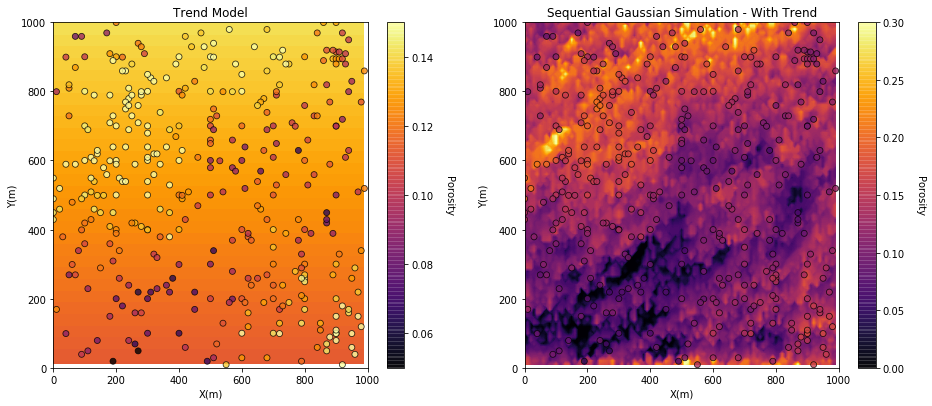

In [118]:
trend = np.zeros((ny,nx))
for iy in range(0,ny):
    for ix in range(0,nx):
        trend[iy,ix] = -1*(iy-ny/2)/(ny)*0.03+.127
    
sim_trend = sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=2,colocorr=0.0,sec_map=trend,vario=vario)

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno

plt.subplot(121)
GSLIB.locpix_st(trend,xmin,xmax,ymin,ymax,xsiz,0.05,0.15,df,'X','Y','Porosity','Trend Model','X(m)','Y(m)','Porosity',cmap)

plt.subplot(122)
GSLIB.locpix_st(sim_trend,xmin,xmax,ymin,ymax,xsiz,0.0,0.30,df,'X','Y','Porosity','Sequential Gaussian Simulation - With Trend','X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()


In [140]:
trend = np.zeros((ny,nx))
for iy in range(0,ny):
    for ix in range(0,nx):
        trend[iy,ix] = -1*(iy-ny/2)/(ny)*0.03+.127
    
sim_colc = sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=4,colocorr=0.6,sec_map=trend,vario=vario)

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno

plt.subplot(121)
GSLIB.locpix_st(trend,xmin,xmax,ymin,ymax,xsiz,0.05,0.15,df,'X','Y','Porosity','Trend Model','X(m)','Y(m)','Porosity',cmap)

plt.subplot(122)
GSLIB.locpix_st(sim_colc,xmin,xmax,ymin,ymax,xsiz,0.0,0.30,df,'X','Y','Porosity','Sequential Gaussian Simulation - With Trend','X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

MAXKR1
21

 Data for SGSIM: Number of acceptable data   = 368
                 Number trimmed                = 0
                 Weighted Average              = 0.127
                 Weighted Variance             = 0.0009
                 Weighted Transformed Average  = 0.0002
                 Weighted Transformed Variance = 0.997
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.1272
                 Equal Weighted Variance    = 0.0001
 Transforming Secondary Data with
 variance reduction of 1.0
Setting up rotation matrices for variogram and search
MaxCov = 1.0
Working on realization number 0
   currently on node 0
MAXKR1
21
(21,)
neq
11
9890
s
(11,)
lvm
(10000,)
MAXKR1
21
(21,)
neq
11
3076
s
(11,)
lvm
(10000,)
         conditional mean and stdev:  6.269289037410905,0.0
         simulated value:    6.269289037410905
MAXKR1
21
(21,)
neq
11
788
s
(11,)
lvm
(10000,)
MAXKR1
21
(21,)
neq
11
-27
s
(11,)
lvm
(10000,)
MAXKR1
21
(21,)
neq
11


LinAlgError: Singular matrix

In [75]:
from scipy import stats
stats.describe(trend.flatten())

DescribeResult(nobs=10000, minmax=(0.09853, 0.1015), mean=0.100015, variance=7.499999999999999e-07, skewness=-3.652006881489788e-15, kurtosis=-1.2002400240023998)


 Data for SGSIM: Number of acceptable data   = 2
                 Number trimmed                = 0
                 Weighted Average              = 1.05
                 Weighted Variance             = 0.9025
                 Weighted Transformed Average  = 1.05
                 Weighted Transformed Variance = 0.9025
Setting up rotation matrices for variogram and search
MaxCov = 1.0
Working on realization number 0
   currently on node 0
   currently on node 1
   currently on node 2
   currently on node 3
   currently on node 4
   currently on node 5
   currently on node 6
   currently on node 7
   currently on node 8
Reassigning data to nodes

 Realization 0: number   = 9
                                   mean     = 1.6119 (close to 0.0?)
                                   variance = 0.0231 (close to gammabar(V,V)? approx. 1.0)


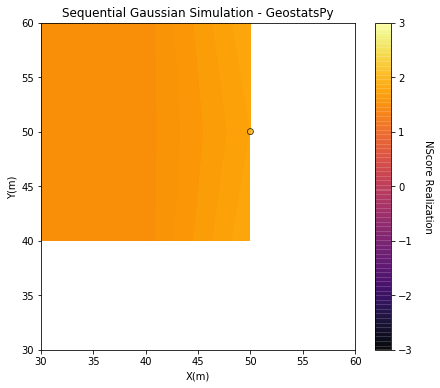

In [46]:
nx = 3; ny = 3; xsiz = 10.0; ysiz = 10.0; xmn = 35.0; ymn = 35.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 20; radius = 100; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=500,hmin1=500)
tmin = -999; tmax = 999

x = [50,10000.6]; y = [50,10000.5]; vr = [2,0.1]
df_small = pd.DataFrame({'X':x,'Y':y,'Porosity':vr})

sim = sgsim(df_small,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=0,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=-3.0,zmax=3.0,ltail=1,ltpar=-3.0,utail=1,utpar=3.0,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

xmin = 30.0; xmax = 60.0; ymin = 30.0; ymax = 60.0; cmap = plt.cm.inferno
plt.subplot(221)
GSLIB.locpix_st(sim,xmin,xmax,ymin,ymax,xsiz,-3,3,df_small,'X','Y','Porosity','Sequential Gaussian Simulation - GeostatsPy','X(m)','Y(m)','NScore Realization',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()


 Data for SGSIM: Number of acceptable data   = 368
                 Number trimmed                = 0
                 Weighted Average              = 0.127
                 Weighted Variance             = 0.0009
                 Weighted Transformed Average  = 0.0002
                 Weighted Transformed Variance = 0.997
Setting up rotation matrices for variogram and search
MaxCov = 1.0
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0007 (close to 0.0?)
                                   variance = 1.0741 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data   = 368
                 Number trimmed               

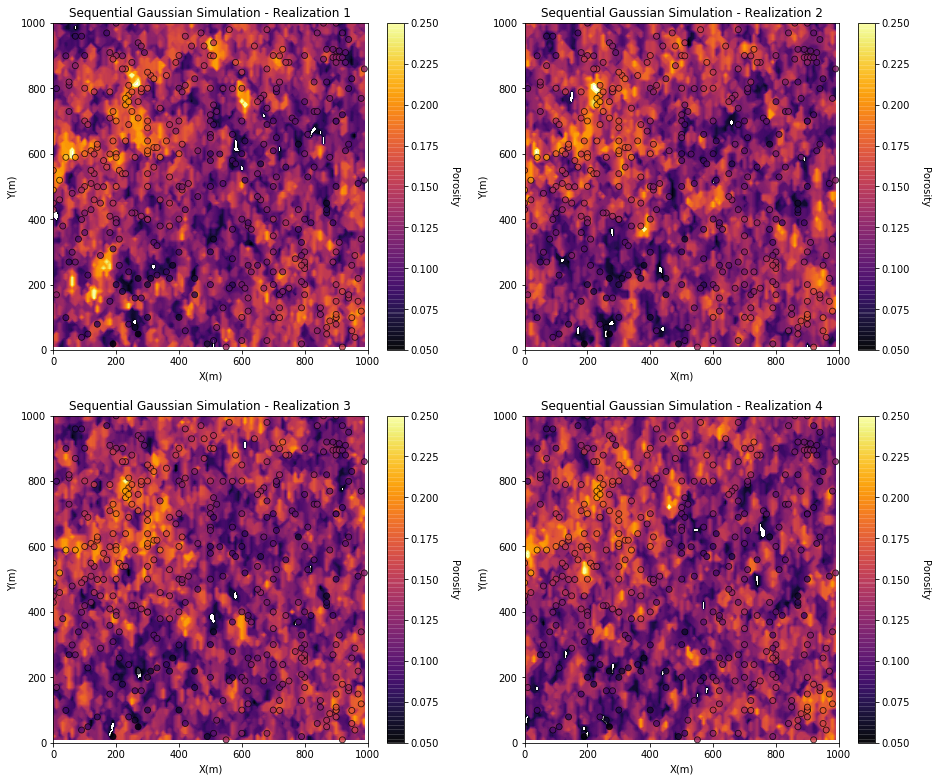

In [17]:
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 20; radius = 50; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=50,hmin1=50)
tmin = -999; tmax = 999

sim = sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim2 = sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73072,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim3 = sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73071,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim4 = sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73070,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(221)
GSLIB.locpix_st(sim,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 1','X(m)','Y(m)','Porosity',cmap)

plt.subplot(222)
GSLIB.locpix_st(sim2,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 2','X(m)','Y(m)','Porosity',cmap)

plt.subplot(223)
GSLIB.locpix_st(sim3,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 3','X(m)','Y(m)','Porosity',cmap)

plt.subplot(224)
GSLIB.locpix_st(sim4,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 4','X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()


 Data for SGSIM: Number of acceptable data   = 368
                 Number trimmed                = 0
                 Weighted Average              = 0.127
                 Weighted Variance             = 0.0009
                 Weighted Transformed Average  = 0.0002
                 Weighted Transformed Variance = 0.997
Setting up rotation matrices for variogram and search
MaxCov = 1.0
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1994 (close to 0.0?)
                                   variance = 0.9465 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data   = 368
                 Number trimmed               

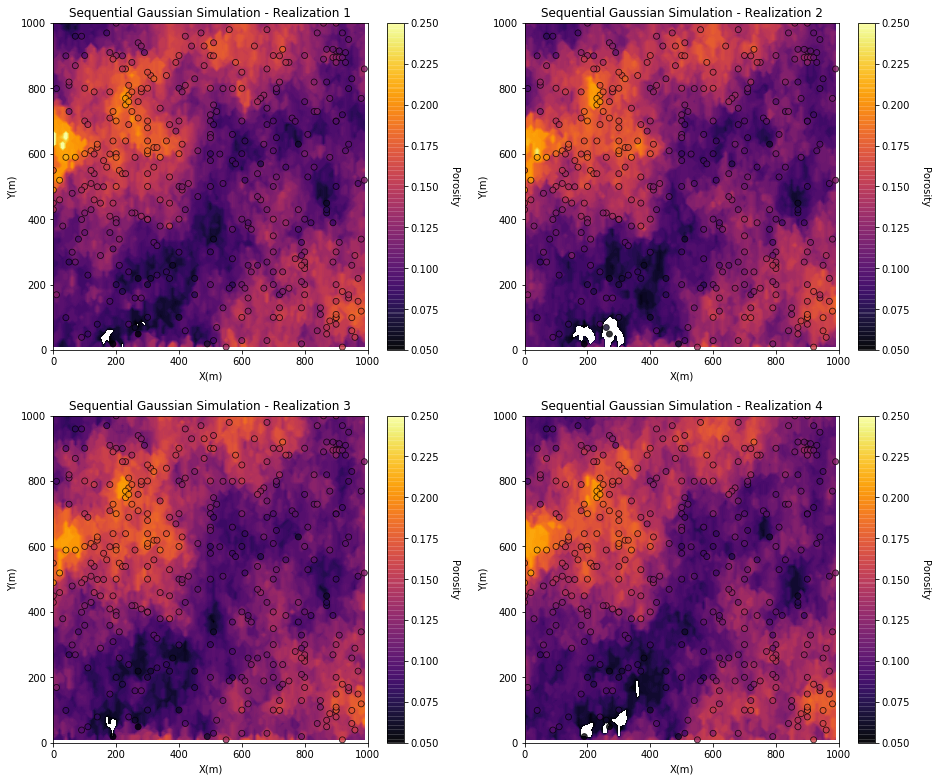

In [16]:
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 20; radius = 100; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=500,hmin1=500)
tmin = -999; tmax = 999

sim = sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim2 = sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73072,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim3 = sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73071,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim4 = sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73070,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(221)
GSLIB.locpix_st(sim,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 1','X(m)','Y(m)','Porosity',cmap)

plt.subplot(222)
GSLIB.locpix_st(sim2,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 2','X(m)','Y(m)','Porosity',cmap)

plt.subplot(223)
GSLIB.locpix_st(sim3,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 3','X(m)','Y(m)','Porosity',cmap)

plt.subplot(224)
GSLIB.locpix_st(sim4,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 4','X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()


 Data for SGSIM: Number of acceptable data   = 368
                 Number trimmed                = 0
                 Weighted Average              = 0.127
                 Weighted Variance             = 0.0009
                 Weighted Transformed Average  = 0.0002
                 Weighted Transformed Variance = 0.997
Setting up rotation matrices for variogram and search
MaxCov = 1.0
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.106 (close to 0.0?)
                                   variance = 1.0882 (close to gammabar(V,V)? approx. 1.0)


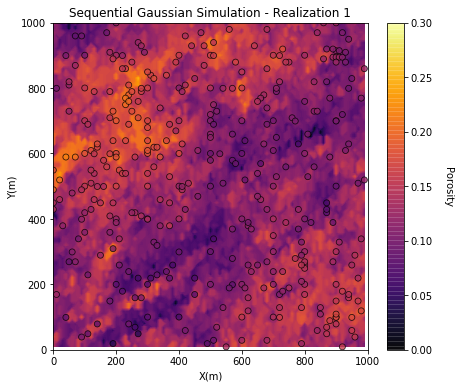

In [48]:
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 10; radius = 200; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=200,hmin1=50)
tmin = -999; tmax = 999

sim_anis = sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(221)
GSLIB.locpix_st(sim_anis,xmin,xmax,ymin,ymax,xsiz,0.0,0.30,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 1','X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

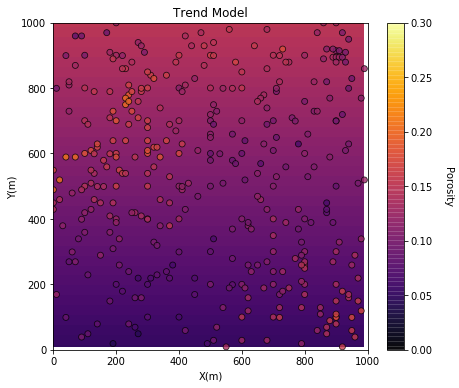


 Data for SGSIM: Number of acceptable data   = 368
                 Number trimmed                = 0
                 Weighted Average              = 0.127
                 Weighted Variance             = 0.0009
                 Weighted Transformed Average  = 0.0002
                 Weighted Transformed Variance = 0.997


NameError: name 'nreal' is not defined

In [55]:
trend = np.zeros((ny,nx))
for iy in range(0,ny):
    for ix in range(0,nx):
        trend[iy,ix] = -1*(iy-ny/2)/(ny)*0.1+.1
    
plt.subplot(221)
GSLIB.locpix_st(trend,xmin,xmax,ymin,ymax,xsiz,0.0,0.30,df,'X','Y','Porosity','Trend Model','X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

sim_anis = sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=2,colocorr=0.0,sec_map=trend,vario=vario)


In [ ]:
vr = np.array((1,2,3,4,5))
vr

In [ ]:
nx = 10; ny = 1; xsiz = 1.0; ysiz = 1.0; xmn = 0.5; ymn = 0.5; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 20; radius = 20; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=30.0,hmin1=30.0)
tmin = -999; tmax = 999
x = [0.6,8.6]; y = [0.5,0.5]; vr = [-0.5,3.0]
df_small = pd.DataFrame({'x':x,'y':y,'vr':vr})

sim = sgsim(df_small,'x','y','vr',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=0,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=-3.0,zmax=3.0,ltail=1,ltpar=-3.0,utail=1,utpar=3.0,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim

In [ ]:
seed = 73073
np.random.seed(seed)
print(np.random.rand())
print(np.random.rand())
print(np.random.rand())
x = np.random.rand(3,3)
print(x)

I hope you find this code and demonstration useful. I'm always happy to discuss geostatistics, statistical modeling, uncertainty modeling and machine learning,

*Michael*

**Michael Pyrcz**, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
On Twitter I'm the **GeostatsGuy** and on YouTube my lectures are on the channel, **GeostatsGuy Lectures**.